In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
import re
from os.path import expanduser


# Get libertine font
from matplotlib.font_manager import _rebuild; _rebuild()
import matplotlib.font_manager as font_manager
# ??plt.use('Agg')
fontpath = expanduser('~/Library/Fonts/LinLibertine_R.otf')
print('fontpath', fontpath)
prop = font_manager.FontProperties(fname=fontpath)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['text.usetex'] = False

print(len(font_manager.findSystemFonts()))

%matplotlib inline

fontpath /Users/fboemer/Library/Fonts/LinLibertine_R.otf
216


In [4]:
def parse_results(file_name):
    re_time = r'.*Total time (.*) \(ms\)'
    runtime = None
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            #print(line)
            if re.match(re_time, line):
                match = re.match(re_time, line)
                runtime = float(match.groups()[0])
                
    assert(runtime is not None)
    
    return runtime


In [5]:
folder = './results/'
best_times = []


num_threads = [1, 2, 4, 8, 16, 32, 56]
thread_runtimes = {}
for nt in num_threads:
    thread_runtimes[nt] = []

omp1_times = []
naive_times = []
for i in range(1,11):
    naive_file = folder + 'naive_recsaling_' + str(i) + '.txt'
    naive_time = parse_results(naive_file)
    naive_times.append(naive_time)
    
for nt in num_threads:
    for i in range(1,11):
        filename = folder + 'best_nt' + str(nt) + '_' + str(i) + '.txt'
        runtime = parse_results(filename)
        thread_runtimes[nt].append(runtime)
    
def fmt_rescaling_line(times):
    batch_size = 4096.
    times_sec = [time / 1000. for time in times]
    amortized_time_ms = np.round(np.mean(times) / batch_size, 2)
    
    ret = str(amortized_time_ms) + ' & '
    ret += '$' +str(np.round(np.mean(times_sec), 2)) + ' \pm ' + str(np.round(np.std(times_sec), 2)) + '$ \\tabularnewline'
    return ret

def fmt_threading_line(nt, times):
    batch_size = 4096.
    times_sec = [time / 1000. for time in times]
    amortized_time_ms = np.round(np.mean(times) / batch_size, 2)
    
    ret = str(nt) + ' & ' +str(amortized_time_ms) + ' & '
    ret += '$' +str(np.round(np.mean(times_sec), 2)) + ' \pm ' + str(np.round(np.std(times_sec), 2)) + '$ \\tabularnewline'
    return ret

print('naive times')
print(fmt_rescaling_line(naive_times))

print('threaded times')
for nt in num_threads:
    print(fmt_threading_line(nt, thread_runtimes[nt]))

naive times
68.92 & $282.31 \pm 4.92$ \tabularnewline
threaded times
1 & 8.3 & $33.99 \pm 0.47$ \tabularnewline
2 & 4.6 & $18.83 \pm 0.23$ \tabularnewline
4 & 2.36 & $9.65 \pm 0.19$ \tabularnewline
8 & 1.26 & $5.15 \pm 0.04$ \tabularnewline
16 & 0.64 & $2.63 \pm 0.03$ \tabularnewline
32 & 0.55 & $2.24 \pm 0.19$ \tabularnewline
56 & 0.6 & $2.44 \pm 0.21$ \tabularnewline


In [17]:
def plot_threaded_runtimes(thread_runtimes):
    nts = sorted(thread_runtimes.keys())
    times = np.log2([np.mean(thread_runtimes[nt])/1000. for nt in nts])
    x_nts = np.log2(nts)
    x_labels = nts
    
    plt.plot(x_nts, times)
    plt.xlabel('Thread Count')
    plt.xticks(x_nts, nts)

    y_ticks = [1, 2, 3, 4, 5]
    y_labels = [2**y for y in y_ticks]
    plt.yticks(y_ticks, y_labels)
    plt.ylabel('Runtime (s)')
    plt.title('Latency')
    plt.savefig('cryptonets_runtime_vs_threads.png', dpi=300, bbox_inches='tight')

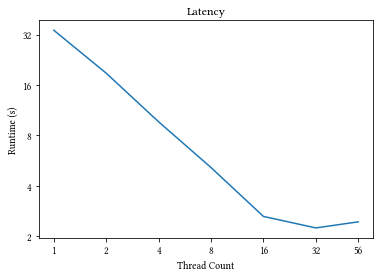

In [18]:
plot_threaded_runtimes(thread_runtimes)